# Vehicle Detection and Tracking

The goal of the project is to write a code that detects and tracks vehicles in a video. Vehicles are searched by moving windows. A Histogram of Oriented Gradients feature is extracted in each window. A classifier is trained to detect vehicles from the extracted features.

## Choosing parameters for Histogram of Oriented Gradients (HOG)

**The HOG feature is extracted according to the parameters such as the number of orientations, pixels per cell, and cells per block. In order to find the best parameter values, a grid is defined with differing values of the parameters and the color spaces. For each grid, a linear support vector machine is trained on a thousand car images and a thousand non-car images.**

First, import the necessary packages.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pandas as pd
import pickle
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

## Function definitions for the HOG features.

 - `convert_clolr()` Converts the color space from RGB to others.
 - `color_hist()` Returns the histograms of the pixel intensities.
 - `bin_spatial()` Returns spatial binning histograms.
 - `get_hog_features()` Returns the HOG feaures for a given image by calling the function `skimage.feature.hog()`.
 - `extract_features()` Takes a list of images as an input, and returns the list of the features.

In [8]:
def convert_color(img, colorspace='YCrCb'):
    if colorspace == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif colorspace == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif colorspace == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif colorspace == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif colorspace == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return img

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                    spatial_features=(32, 32), nbins=32):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        if file[-3:] == 'png':
            image = (image * 255).astype(np.uint8)
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, cspace)
        feature_image[feature_image < 0] = 0

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)

        # Get color features
        spatial_features = bin_spatial(feature_image)
        hist_features = color_hist(feature_image)

        # Scale features and make a prediction
        #test_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
        test_features = np.concatenate((hog_features, spatial_features, hist_features))

        # Append the new feature vector to the features list
        features.append(test_features)

        # Return list of feature vectors
    return features

## Choose the meta parameters for the SVM from the trainings of 600 grid points.

A linear SVM is trained for all possible combinations of the following parameter values:

 - Color space: RGB, HSV, LUV, HLS, YUV, YCrCb.
 - HOG channel: 0, 1, 2, 'ALL'.
 - pixels per cell: 6, 8, 12, 14.
 - orientationx: 6, 9, 12, 14
 
The total number of trained SVMs is 384.

In [3]:
def runGrid(colorspace, orient, pix_per_cell, cell_per_block=2, hog_channel="ALL"):
    car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    # Use linear SVM classifier.
    clf = LinearSVC()
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return score

# Divide up into cars and notcars
images = glob.glob('imgdir/*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Reduce the sample size because HOG features are slow to compute
sample_size = 1000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

cnt = 0
df = pd.DataFrame(columns=['colorspace', 'orient', 'ppc', 'hchann', 'score'])
for h in [0, 1, 2, "ALL"]:
    for o in [6, 9, 12, 14]:
        for p in [6, 8, 12, 14]:
            for cl in ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']:
                best_score = runGrid(cl, o, p, hog_channel=h)
                aRow = {'colorspace':cl, 'orient':o, 'ppc':p,
                        'hchann':h, 'score':best_score}
                df.loc[cnt] = aRow
                cnt += 1
pickle.dump(df, open('df.p', 'wb'))

# Divide up into cars and notcars
images = glob.glob('imgdir/*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Reduce the sample size because HOG features are slow to compute
sample_size = 1000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

cnt = 0
df = pd.DataFrame(columns=['colorspace', 'orient', 'ppc', 'hchann', 'score'])

for h in [0, 1, 2, "ALL"]:
    for o in [6, 9, 12, 14]:
        for p in [6, 8, 12, 14]:
            for cl in ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']:
                best_score = runGrid(cl, o, p, hog_channel=h)
                aRow = {'colorspace':cl, 'orient':o, 'ppc':p,
                        'hchann':h, 'score':best_score}
                df.loc[cnt] = aRow
                cnt += 1
pickle.dump(df, open('df.p', 'wb'))

55 of 384 SVMs marked the best score of 1.0.The mean scores for each choice of the parameters are averaged over the other parameters and shown below:

In [9]:
df = pickle.load(open('df.p', 'rb'))
df.describe()
print(df[df['score'] == df['score'].max()].reset_index())
for g in df.columns[:-1]:
    print(df.groupby(g).mean().sort_values('score'))

    index colorspace orient ppc hchann  score
0       3        HLS      6   6      0    1.0
1      45        HLS      9  14      0    1.0
2      51        HLS     12   6      0    1.0
3      57        HLS     12   8      0    1.0
4      65      YCrCb     12  12      0    1.0
5      75        HLS     14   6      0    1.0
6      79        HSV     14   8      0    1.0
7      81        HLS     14   8      0    1.0
8      93        HLS     14  14      0    1.0
9     100        YUV      6   6      1    1.0
10    124        YUV      9   6      1    1.0
11    133        HSV      9  12      1    1.0
12    148        YUV     12   6      1    1.0
13    152        LUV     12   8      1    1.0
14    155      YCrCb     12   8      1    1.0
15    158        LUV     12  12      1    1.0
16    165        HLS     12  14      1    1.0
17    170        LUV     14   6      1    1.0
18    172        YUV     14   6      1    1.0
19    179      YCrCb     14   8      1    1.0
20    204        RGB      6  12   

I chose the color space 'HLS'. Conditioned on the choice of the color space, the average scores for each parameter values are shown below. Although the orient=14 and pixel_per_cell=14 have the best average score, I chose orient=12 and pixedl_per_cell=8 in order to reduce the training data size.

In [10]:
for g in ['orient', 'ppc', 'hchann']:
    print(df[df['colorspace']=='HLS'].groupby(g).mean().sort_values('score'))

           score
orient          
9       0.994062
6       0.994531
12      0.994687
14      0.995625
        score
ppc          
12   0.993594
6    0.994375
8    0.994687
14   0.996250
           score
hchann          
2       0.992500
1       0.994062
ALL     0.995156
0       0.997188


## Train the Classifier

The parameters for the SVM are chosen from the previous step. Using those parameters, now train an SVM on the whole data set. First, the features are calculated for the car and not-car classes.

In [6]:
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Now train the SVM.

In [7]:
# SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

svc_pickle = {'svc':svc, 'colorspace':colorspace, 'scaler':X_scaler, 'orient':orient, 'pix_per_cell':pix_per_cell,
             'cell_per_block':cell_per_block, 'spatial_size':(32,32), 'hist_bins':32}
pickle.dump(svc_pickle, open('svc_pickle.p', 'wb'))

## Window Search

Read the SVM model from the file. Define the function `find_bboxes()` that performs the moving window search. The HOG features are calculated once, and then reused during the search. The method is applied to the six test images with a fixed window size.

In [11]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
colorspace=dist_pickle["colorspace"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_bboxes(img, ystart, ystop, scale, svc, X_scaler, orient,
                pix_per_cell, cell_per_block, spatial_size, hist_bins):
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, colorspace=colorspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_features, spatial_features, hist_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                bboxes.append(bbox)
    return bboxes

## Search with variable window size

Since the cars that are closer will appear larger, it makes sense to use variable window size for different regions of the images. The function `get_winsize_ftn()` returns a linear function that determines the window size given a y-corrdinate of the bottom of the search box. The funciton `find_bboxes_var()` decides the window sizes, perform the search, and returns the list of the bboxes. The function `find_cars_var()` takes an image as an input, calls `find_bboxes_var()` and draws the boxes.

The search with the variable window size is applied to the six test images.

/home/jdlee/.local/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


4.12447 Seconds to draw boxes


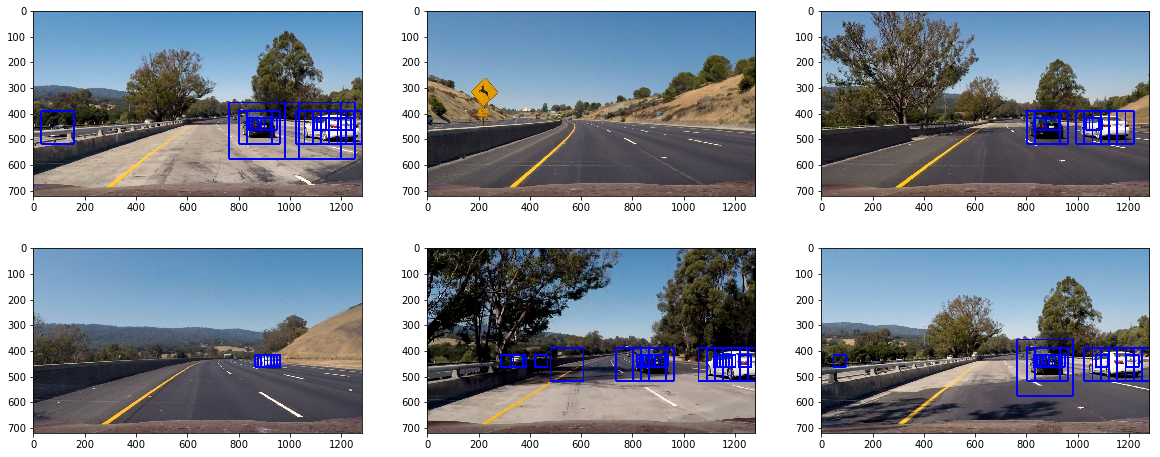

In [12]:
def get_win_range():
    # Minimum and maximum y-coordinates of the search boxes.
    ylow_min_max = np.array([464, 640])
    # Minimum adn maximum window sizes.
    winsize_min_max = np.array([48, 320])
    return ylow_min_max, winsize_min_max

def get_winsize_ftn():
    '''
    Calculate window size as function of ylow'''
    ylow_min_max, winsize_min_max = get_win_range()
    fitftn = np.poly1d(np.polyfit(ylow_min_max, winsize_min_max, 1))
    return fitftn

def get_ylow_list(ylow_min_max, nrows):
    log_grid =np.linspace(np.log(ylow_min_max[0]), np.log(ylow_min_max[1]), nrows)
    grid = np.exp(log_grid).astype(int)
    return grid

def find_bboxes_var(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, nrows=4):
    winsize_model_train = 64

    # Window size as function of ylow
    fitftn = get_winsize_ftn()
    
    # List of the y-coordinates of each row of search windows.
    ylow_min_max, winsize_min_max = get_win_range()
    ylow_list = get_ylow_list(ylow_min_max, nrows)
    
    # Determine the window size for each row.
    winsize_list = fitftn(ylow_list).astype(int)
    
    # Loop through the rows of the search.
    bboxes = []
    for ylow, winsize in zip(ylow_list, winsize_list):
        scale = winsize / winsize_model_train
        ystart = ylow - winsize
        ystop = ylow
        bboxes_row = find_bboxes(img, ystart, ystop, scale, svc, X_scaler, orient,
                                 pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bboxes.extend(bboxes_row)
    return bboxes

def find_cars_var(img, svc, X_scaler, orient,
                  pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    bboxes = find_bboxes_var(img, svc, X_scaler, orient,
                             pix_per_cell, cell_per_block, spatial_size, hist_bins)
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 6)
    return draw_img

test_imgs = glob.glob('test_images/*.jpg')
plt.figure(figsize=(20,8))
t=time.time()
for i, img in enumerate(test_imgs):
    image = mpimg.imread(img)
    image_with_box = find_cars_var(image, svc, X_scaler, orient,
                                   pix_per_cell, cell_per_block, spatial_size, hist_bins)
    plt.subplot(2, 3, i+1)
    plt.imshow(image_with_box)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to draw boxes')

## Removing False Positives

False positives and duplicate boxes can be removed using the heatmaps. For each bbox found from the window search, the pixel values within the boxes are incremented by one. This creates a heat map with higher values around the cars, and lower values in false positives. By applying appropriate threshold, false positives can be removed and unique box can be obtained around each car.

/home/jdlee/.local/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


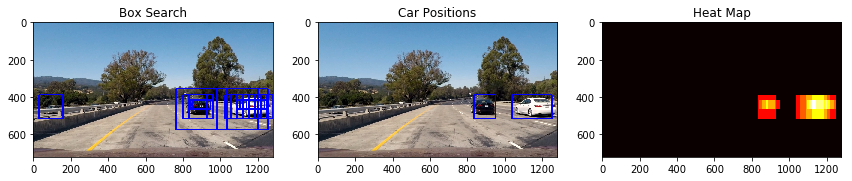

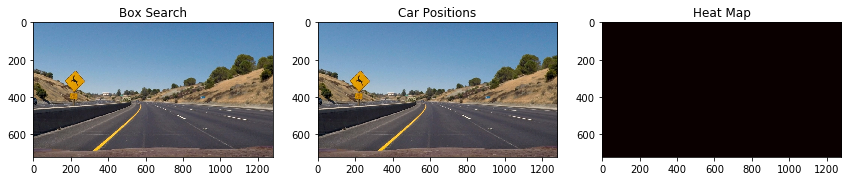

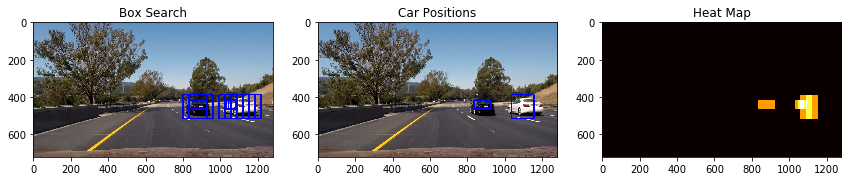

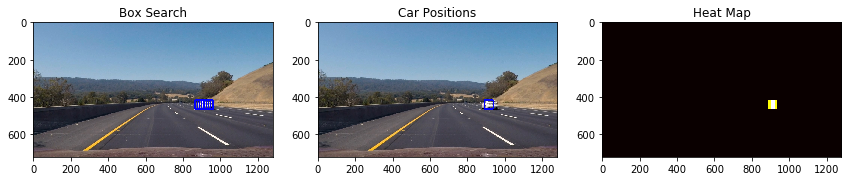

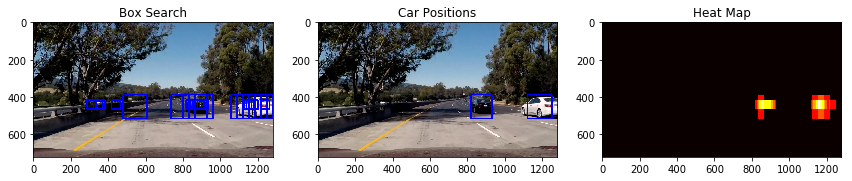

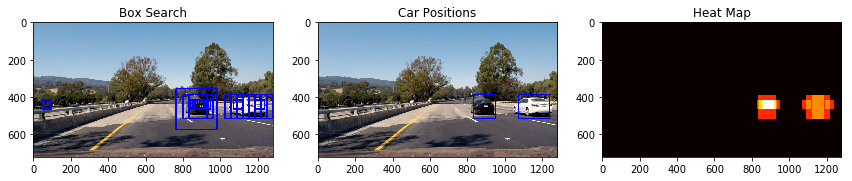

In [13]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def box_big_enough(bbox):
    #return True
    ylow = bbox[1][1]
    lenx = bbox[1][0] - bbox[0][0]
    leny = bbox[1][1] - bbox[0][1]
    winsize_ftn = get_winsize_ftn()
    min_len = winsize_ftn(ylow) / 3
    return lenx > min_len and leny > min_len

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        if box_big_enough(bbox):
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def find_cars_heatmap(img):
    image = mpimg.imread(img)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    box_list = find_bboxes_var(image, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return heatmap, draw_img

for i in range(len(test_imgs)):
    image = mpimg.imread(test_imgs[i])
    heatmap, draw_img = find_cars_heatmap(test_imgs[i])
    image_with_box = find_cars_var(image, svc, X_scaler, orient,
                                   pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    fig = plt.figure(figsize=(12,6))
    plt.subplot(131)
    plt.imshow(image_with_box)
    plt.title('Box Search')
    plt.subplot(132)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(133)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

## Test on Video

In processing the video images, a heat map is formed by calculating the exponential moving average for each pixel. By keeping the history of the boxes in the moving average, the signals can be more robust and the noise can be easily removed.

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

class ProcImgAvg:
    """Callable class that finds cars from the history of images, using heatmap."""
    def __init__(self):
        self.thres_frame = 1
        self.thres_history = 0.2
        self.heat_history = None
        self.wgt = 0.12
        
    def __call__(self, image):
        box_list = find_bboxes_var(image, svc, X_scaler, orient,
                                   pix_per_cell, cell_per_block, spatial_size, hist_bins)

        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = add_heat(heat, box_list)
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat, self.thres_frame)
        
        # Add the heat of the image to the history
        if self.heat_history is None:
            self.heat_history = self.thres_history * heat
        else:
            self.heat_history = self.wgt * heat + (1 - self.wgt) * self.heat_history
        self.heat_history = apply_threshold(self.heat_history, self.thres_history)

        # Visualize the heatmap when displaying    
        self.heat_history = np.clip(self.heat_history, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(self.heat_history)
        result = draw_labeled_bboxes(np.copy(image), labels)
        
        return result

In [16]:
procImg = ProcImgAvg()
project_output = 'output_images/project_svm.mp4'
clip1 = VideoFileClip("../project_video.mp4")
project_clip = clip1.fl_image(procImg).subclip(20,20.3)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_images/project_svm.mp4
[MoviePy] Writing video output_images/project_svm.mp4


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_svm.mp4 

CPU times: user 4.86 s, sys: 36 ms, total: 4.89 s
Wall time: 4.98 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))